In [ ]:
#Download and unzip the dataset
!gdown 1--CmXocqkrcPR-bbSDztnxBM9dBC8uUJ
!unzip /content/IconDomainVQAData.zip


# Install the necessary libraries
!pip install -q peft transformers bitsandbytes datasets

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: IconDomainVQAData/test_data/test_data/55745/image.png  
  inflating: __MACOSX/IconDomainVQAData/test_data/test_data/55745/._image.png  
  inflating: IconDomainVQAData/test_data/test_data/24184/data.json  
  inflating: __MACOSX/IconDomainVQAData/test_data/test_data/24184/._data.json  
  inflating: IconDomainVQAData/test_data/test_data/24184/image.png  
  inflating: __MACOSX/IconDomainVQAData/test_data/test_data/24184/._image.png  
  inflating: IconDomainVQAData/test_data/test_data/62791/data.json  
  inflating: __MACOSX/IconDomainVQAData/test_data/test_data/62791/._data.json  
  inflating: IconDomainVQAData/test_data/test_data/62791/image.png  
  inflating: __MACOSX/IconDomainVQAData/test_data/test_data/62791/._image.png  
  inflating: IconDomainVQAData/test_data/test_data/31664/data.json  
  inflating: __MACOSX/IconDomainVQAData/test_data/test_data/31664/._data.json  
  inflating: IconDomainVQADa

In [ ]:
import os, json
from PIL import Image

from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim

from peft import LoraConfig, get_peft_model

from transformers import BlipProcessor, BlipForQuestionAnswering

from datasets import load_dataset, DatasetDict

In [ ]:
data_path='/content/IconDomainVQAData'
ds = load_dataset("json", data_files=f"{data_path}/train.jsonl")
ds

"""
DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'ques_type', 'grade', 'label', 'pid', 'unit', 'hint'],
        num_rows: 14551
    })
})
"""

Generating train split: 0 examples [00:00, ? examples/s]

"\nDatasetDict({\n    train: Dataset({\n        features: ['question', 'answer', 'ques_type', 'grade', 'label', 'pid', 'unit', 'hint'],\n        num_rows: 14551\n    })\n})\n"

In [ ]:
# Build Dataset

class VQADataset(Dataset):

    def __init__(self, dataset, processor, data_path):
        self.dataset = dataset
        self.processor = processor
        self.data_path = data_path

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        question = self.dataset[idx]['question']
        answer = self.dataset[idx]['answer']
        image_id = self.dataset[idx]['pid']
        image_path = os.path.join(self.data_path, f"train_fill_in_blank/train_fill_in_blank/{image_id}/image.png")
        image = Image.open(image_path).convert("RGB")
        text = question

        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        labels = self.processor.tokenizer.encode(answer, max_length=8, pad_to_max_length=True, return_tensors="pt")
        encoding['labels'] = labels
        for k, v in encoding.items():
            encoding[k] = v.squeeze()

        return encoding

In [ ]:
model_id = "Salesforce/blip-vqa-base"
processor = BlipProcessor.from_pretrained(model_id)
model = BlipForQuestionAnswering.from_pretrained(model_id)

lora_config = LoraConfig(
                    r=16,
                    lora_alpha=32,
                    lora_dropout=0.05,
                    bias="none",
                    target_modules=["query", "key"]
                    )

model = get_peft_model(model, lora_config )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.print_trainable_parameters()

"""
trainable params: 2,359,296 || all params: 387,031,868 || trainable%: 0.6096
"""

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

trainable params: 2,359,296 || all params: 387,031,868 || trainable%: 0.6096


'\ntrainable params: 2,359,296 || all params: 387,031,868 || trainable%: 0.6096\n'

In [ ]:
train_dataset = VQADataset(dataset=ds["train"],
                           processor=processor,
                           data_path=data_path)
val_dataset = VQADataset(dataset=ds["train"],
                           processor=processor,
                           data_path=data_path)

In [ ]:
batch_size=8
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)
val_dataloader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            pin_memory=True)

In [ ]:
# ======== Set up========
#
optimizer = optim.AdamW(model.parameters(),
                        lr=4e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                             gamma=0.9,
                                             last_epoch=-1,
                                             verbose=True)
n_epochs = 1
min_val_loss = float("inf")
scaler = torch.cuda.amp.GradScaler()

# ======== Training ========
#
for epoch in range(n_epochs):

    # Training setting
    train_loss = []
    model.train()
    for idx, batch in zip(tqdm(range(len(train_dataloader)),
                               desc=f"Training Batch {epoch+1}"), train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)
        attention_masked = batch.pop('attention_mask').to(device)
        labels = batch.pop('labels').to(device)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            labels=labels)

        loss = outputs.loss
        train_loss.append(loss.item())

        ## Backward propogation
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    # Validating setting
    val_loss = []
    model.eval()
    for idx, batch in zip(tqdm(range(len(val_dataloader)),
                               desc=f"Validating Batch {epoch+1}"), val_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)
        attention_masked = batch.pop('attention_mask').to(device)
        labels = batch.pop('labels').to(device)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            attention_mask=attention_masked,
                            labels=labels)

        loss = outputs.loss
        val_loss.append(loss.item())

        avg_train_loss = sum(train_loss)/len(train_loss)
        avg_val_loss = sum(val_loss)/len(val_loss)
        lr_per_epoch = optimizer.param_groups[0]["lr"]
    print(f"Epoch: {epoch + 1} - Training Loss: {avg_train_loss} - Eval Loss: {avg_val_loss} - LR: {lr_per_epoch}")

    scheduler.step()

    if avg_val_loss < min_val_loss:
        model.save_pretrained('./save_model', from_pt=True)
        print ("Saved model to ./save_model")
        min_eval_loss = avg_val_loss
processor.save_pretrained ("./save_model", from_pt=True )

<ipython-input-8-12c28c374a29>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training Batch 1:   0%|          | 0/1819 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific 

Epoch: 1 - Training Loss: 7.676989510794666 - Eval Loss: 7.8795850252043484 - LR: 4e-05
Saved model to ./save_model


[]

In [ ]:
retrain_model_dir = './save_model'
processor = BlipProcessor.from_pretrained(retrain_model_dir)
model = BlipForQuestionAnswering.from_pretrained(retrain_model_dir).to(device)

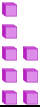

In [ ]:
test_data_dir = f"{data_path}/test_data/test_data"
samples = os.listdir(test_data_dir)
sample_path = os.path.join(test_data_dir, samples[0])
json_path = os.path.join(sample_path, "data.json")

with open(json_path, "r") as json_file:
    data = json.load(json_file)
    question = 'what is in the image'
    image_id = data["id"]

"""
question
"""



image_path = os.path.join(test_data_dir, f"{image_id}", "image.png")
image = Image.open(image_path).convert("RGB")
image


In [ ]:
encoding = processor(image,
                     question,
                     return_tensors="pt",truncation=True).to(device, torch.float16)

outputs = model.generate(**encoding)

generated_text = processor.decode(outputs[0], skip_special_tokens=True)

generated_text

'box'